# Mask RCNN on Oxford IIIT Pet Dataset


This notebook creates the tfrecords file outof the dataset

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
from lxml import etree
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from object_detection.utils import label_map_util
from object_detection.utils import dataset_util
import PIL.Image
import io

## Get the Dataset

In [2]:
pet_data, pet_info = tfds.load('oxford_iiit_pet', with_info=True, data_dir='dataset')

In [3]:
pet_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [4]:
pet_data.keys()

dict_keys(['test', 'train'])

In [5]:
pet_data

{'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

In [6]:
train_data = pet_data['train']
test_data = pet_data['test']

In [7]:
train_data

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>

In [8]:
def show_example(dataset):
    for data in dataset.take(2):
        print(data.keys())
        print(data['file_name'])
        plt.imshow(data['image'])
        plt.show()
        plt.imshow(data['segmentation_mask'])
        print(data['segmentation_mask'].shape)
        plt.show()
        print(data['species'].numpy())
        print(data['label'].numpy())
        break

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
tf.Tensor(b'Sphynx_158.jpg', shape=(), dtype=string)


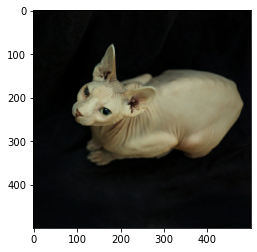

(500, 500, 1)


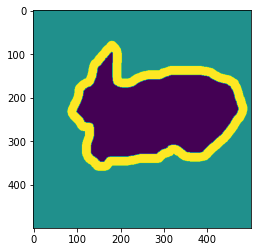

0
33


In [9]:
show_example(train_data)

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
tf.Tensor(b'leonberger_73.jpg', shape=(), dtype=string)


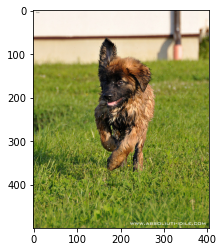

(500, 403, 1)


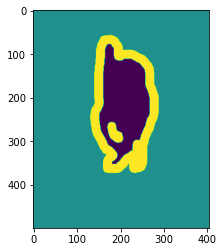

1
19


In [10]:
show_example(test_data)

Taking Species(Cat or Dog) as the classification task in place of label(defining the breed of the cat/dog) as the classification output.

## Generate the LabelMap pbtxt file

In [18]:
with open('labelmap.pbtxt', 'w') as f:
    f.write(
        'item {\n'+
        '    id: 1\n'+
        '    name: \'Cat\'\n'+
        '}\n'+
        'item {\n'+
        '    id: 2\n'+
        '    name: \'Dog\'\n'+
        '}'
           )

In [12]:
!mkdir mask_rcnn_train

In [19]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
label_map_dict = label_map_util.get_label_map_dict(label_map)

In [20]:
label_map_dict

{'Cat': 1, 'Dog': 2}

## Generate the tfrecord files from the images

In [134]:
def dict_to_tfrecord(data, image_path, mask_path, label_map_dict):
    image_w = int(data['size']['width'])
    image_h = int(data['size']['height'])
    
    image_name_b = data['filename'].encode('utf8')

    with open(image_path, 'rb') as fid:
        image_encoded = fid.read()
    #encoded_jpg_io = io.BytesIO(image_encoded)
    #image = PIL.Image.open(encoded_jpg_io)
    image_format = b'JPEG'
    
    with open(mask_path, 'rb') as fid:
        mask_encoded = fid.read()
    encoded_png_io = io.BytesIO(mask_encoded)
    mask = PIL.Image.open(encoded_png_io)
    #mask_format = b'PNG'
    
    mask_np = np.asarray(mask)
    mask_x_indices_nonbg = np.any(mask_np != 2, axis=0)
    mask_y_indices_nonbg = np.any(mask_np != 2, axis=1)
    mask_x_indices = np.where(mask_x_indices_nonbg)
    mask_y_indices = np.where(mask_y_indices_nonbg)

    xmins = []
    ymins = []
    xmaxs = []
    ymaxs = []
    labels = []
    masks = []
    classes = []
    if 'objects' in data:
        for obj in data['objects']:
            xmin = float(np.min(mask_x_indices))
            xmax = float(np.max(mask_x_indices))
            ymin = float(np.min(mask_y_indices))
            ymax = float(np.max(mask_y_indices))

            xmins.append(xmin/image_w)
            xmaxs.append(xmax/image_w)
            ymins.append(ymin/image_h)
            ymaxs.append(ymax/image_h)
            
            label = obj['name']
            labels.append(label.encode('utf8'))
    
            #mask_b = (mask_np != 2).astype(np.uint8)
            #masks.append(mask_b)
            masks.append(mask_encoded)
            
            obj_class = label_map_dict[label]
            classes.append(obj_class.encode('utf8'))

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(image_h),
        'image/width': dataset_util.int64_feature(image_w),
        'image/filename': dataset_util.bytes_feature(image_name_b),
        'image/source_id': dataset_util.bytes_feature(image_name_b),
        'image/encoded': dataset_util.bytes_feature(image_encoded),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(labels),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
        'image/object/mask': dataset_util.bytes_list_feature(masks)
    }))
    
    return example

In [137]:
def generate_tfrecords():
    image_dir = r'dataset/downloads/extracted/TAR_GZ.robots.ox.ac.uk_vgg_pets_imageswMR1o1DWRq_DHWToagdXedb7P88RHpceK3WqG77VVwU.tar.gz/images'
    annotation_dir = r'dataset/downloads/extracted/TAR_GZ.robots.ox.ac.uk_vgg_pets_annotationsL8B_bMDM0_iUhyDddl6Yu-1togBm2g5ZH8E6r80wOQo.tar.gz/annotations/trimaps'
    xml_dir = r'dataset/downloads/extracted/TAR_GZ.robots.ox.ac.uk_vgg_pets_annotationsL8B_bMDM0_iUhyDddl6Yu-1togBm2g5ZH8E6r80wOQo.tar.gz/annotations/xmls'
    train_val_txt = r'dataset/downloads/extracted/TAR_GZ.robots.ox.ac.uk_vgg_pets_annotationsL8B_bMDM0_iUhyDddl6Yu-1togBm2g5ZH8E6r80wOQo.tar.gz/annotations/trainval.txt'
    
    file_names = dataset_util.read_examples_list(train_val_txt)
    random.seed(42)
    random.shuffle(file_names)
    num_examples = len(file_names)
    num_train = int(0.7 * num_examples)
    train_examples = file_names[:num_train]
    val_examples = file_names[num_train:]
    
    train_output_path = 'pet_faces_train.tfrecord'#os.path.join('output', 'pet_faces_train.tfrecord')
    val_output_path = 'pet_faces_val.tfrecord'#os.path.join('output', 'pet_faces_val.tfrecord')
    
    def create_tfrecord(record_name, examples):
        writer = tf.io.TFRecordWriter(record_name)
        for idx, file_name in enumerate(examples):
            if idx % 100 == 0:
                print('Done processing {} images'.format(idx))

            xml_path = os.path.join(xml_dir, file_name + '.xml')
            mask_path = os.path.join(annotation_dir, file_name + '.png')
            image_path = os.path.join(image_dir, file_name + '.jpg')

            if not os.path.exists(xml_path):
                print('XML file for {} does not exist'.format(file_name))
                continue

            with open(xml_path, 'r') as fid:
                xml_str = fid.read()
            xml = etree.fromstring(xml_str)
            data = dataset_util.recursive_parse_xml_to_dict(xml)['annotation']

            record_data = dict_to_tfrecord(data, image_path, mask_path, label_map_dict)
            writer.write(record_data.SerializeToString())
        writer.close()
        
    create_tfrecord(train_output_path, train_examples)
    create_tfrecord(val_output_path, val_examples)

In [138]:
generate_tfrecords()

Done processing 0 images


/home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/object_detection/utils/dataset_util.py:83: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


Done processing 100 images
Done processing 200 images
Done processing 300 images
Done processing 400 images
Done processing 500 images
XML file for Egyptian_Mau_14 does not exist
XML file for saint_bernard_15 does not exist
Done processing 600 images
XML file for Ragdoll_199 does not exist
Done processing 700 images
Done processing 800 images
Done processing 900 images
Done processing 1000 images
Done processing 1100 images
Done processing 1200 images
Done processing 1300 images
Done processing 1400 images
XML file for Egyptian_Mau_186 does not exist
Done processing 1500 images
XML file for Bengal_175 does not exist
Done processing 1600 images
Done processing 1700 images
XML file for samoyed_10 does not exist
Done processing 1800 images
Done processing 1900 images
Done processing 2000 images
Done processing 2100 images
XML file for Egyptian_Mau_156 does not exist
Done processing 2200 images
Done processing 2300 images
Done processing 2400 images
Done processing 2500 images
XML file for